PyG Version: 2.7.0
NetworkX Version: 3.5
--- 1. Starting to load data files ---
Successfully loaded: concept.csv (Rows: 8263683)
Successfully loaded: sampled_person.csv (Rows: 2000)
Successfully loaded: sampled_condition_occurrence.csv (Rows: 761822)
Successfully loaded: sampled_drug_exposure.csv (Rows: 777234)
Successfully loaded: sampled_observation.csv (Rows: 1643088)
--- Data loading complete ---
--- 2. Starting to build heterogeneous graph (HeteroData) ---
Processing nodes...
Processing edges...
Correctly building (visit, prescribed, drug) edges...


Building drug edges:   0%|          | 0/220832 [00:00<?, ?it/s]

Adding reverse edges (ToUndirected)...
--- Graph construction complete! ---

--- Final Graph Summary ---
HeteroData(
  person={
    num_nodes=2000,
    x=[2000, 3],
    person_id=[2000],
  },
  visit={
    num_nodes=210610,
    visit_id=[210610],
  },
  disease={
    num_nodes=6376,
    name=[6376],
    concept_id=[6376],
  },
  drug={
    num_nodes=4110,
    name=[4110],
    concept_id=[4110],
  },
  symptom={
    num_nodes=325,
    name=[325],
    concept_id=[325],
  },
  (person, had_visit, visit)={ edge_index=[2, 210610] },
  (visit, had_condition, disease)={ edge_index=[2, 408096] },
  (visit, had_symptom, symptom)={ edge_index=[2, 471773] },
  (visit, prescribed, drug)={
    edge_index=[2, 220832],
    edge_attr=[220832, 2],
  },
  (visit, rev_had_visit, person)={ edge_index=[2, 210610] },
  (disease, rev_had_condition, visit)={ edge_index=[2, 408096] },
  (symptom, rev_had_symptom, visit)={ edge_index=[2, 471773] },
  (drug, rev_prescribed, visit)={
    edge_index=[2, 220832],
 

Analyzing all drugs:   0%|          | 0/4110 [00:00<?, ?it/s]

--- Metric calculation complete ---
--- 4. Generating Quadrant Analysis Plot ---
Displaying Quadrant Analysis Plot...

--- Quadrant Analysis Insights ---

**Quadrant 1: Chronic, Broad-Spectrum (Top Right)**
Drugs for common, chronic conditions. (e.g., Metformin, Lisinopril)
                     No matching concept
150 ML sodium chloride 9 MG/ML Injection
      2 ML ondansetron 2 MG/ML Injection

**Quadrant 2: Chronic, Specialized (Top Left)**
Drugs for rare or specialized chronic conditions. (e.g., Chemotherapy, specific biologics)
                methotrexate 2.5 MG Oral Tablet
0.6 ML pegfilgrastim 10 MG/ML Prefilled Syringe
         5 ML palonosetron 0.05 MG/ML Injection

**Quadrant 3: Acute, Broad-Spectrum (Bottom Right)**
Common 'one-time' treatments. (e.g., Ibuprofen, common antibiotics)
   rocuronium bromide 10 MG/ML Injectable Solution
phenylephrine hydrochloride 10 MG/ML Injectable...
calcium chloride 0.0014 MEQ/ML / potassium chlo...

**Quadrant 4: Acute, Specialized (Bottom L

Building Drug-Drug graph (Jaccard):   0%|          | 0/3938 [00:00<?, ?it/s]

Drug-Drug graph built: 3916 nodes, 1997275 edges.
--- 6. Calculating Betweenness Centrality ---

--- Bridging Drug Analysis (Top 10) ---
| drug_name             |   betweenness_centrality |   spectrum_score |   persistence_score |
|:----------------------|-------------------------:|-----------------:|--------------------:|
| ferrous lactate       |              106898.7591 |             1058 |              1.3813 |
| calcium pyrophosphate |               92222.9264 |               94 |              1.0000 |
| ferrous carbonate     |               53449.3793 |             1058 |              1.3813 |
| calcium malate        |               46111.4629 |               94 |              1.0000 |
| iron,peptonized       |               26724.6894 |             1058 |              1.3813 |
| calcium               |               23055.7311 |               94 |              1.0000 |
| ferrous chloride      |               13362.3445 |             1058 |              1.3813 |
| calcium carbona

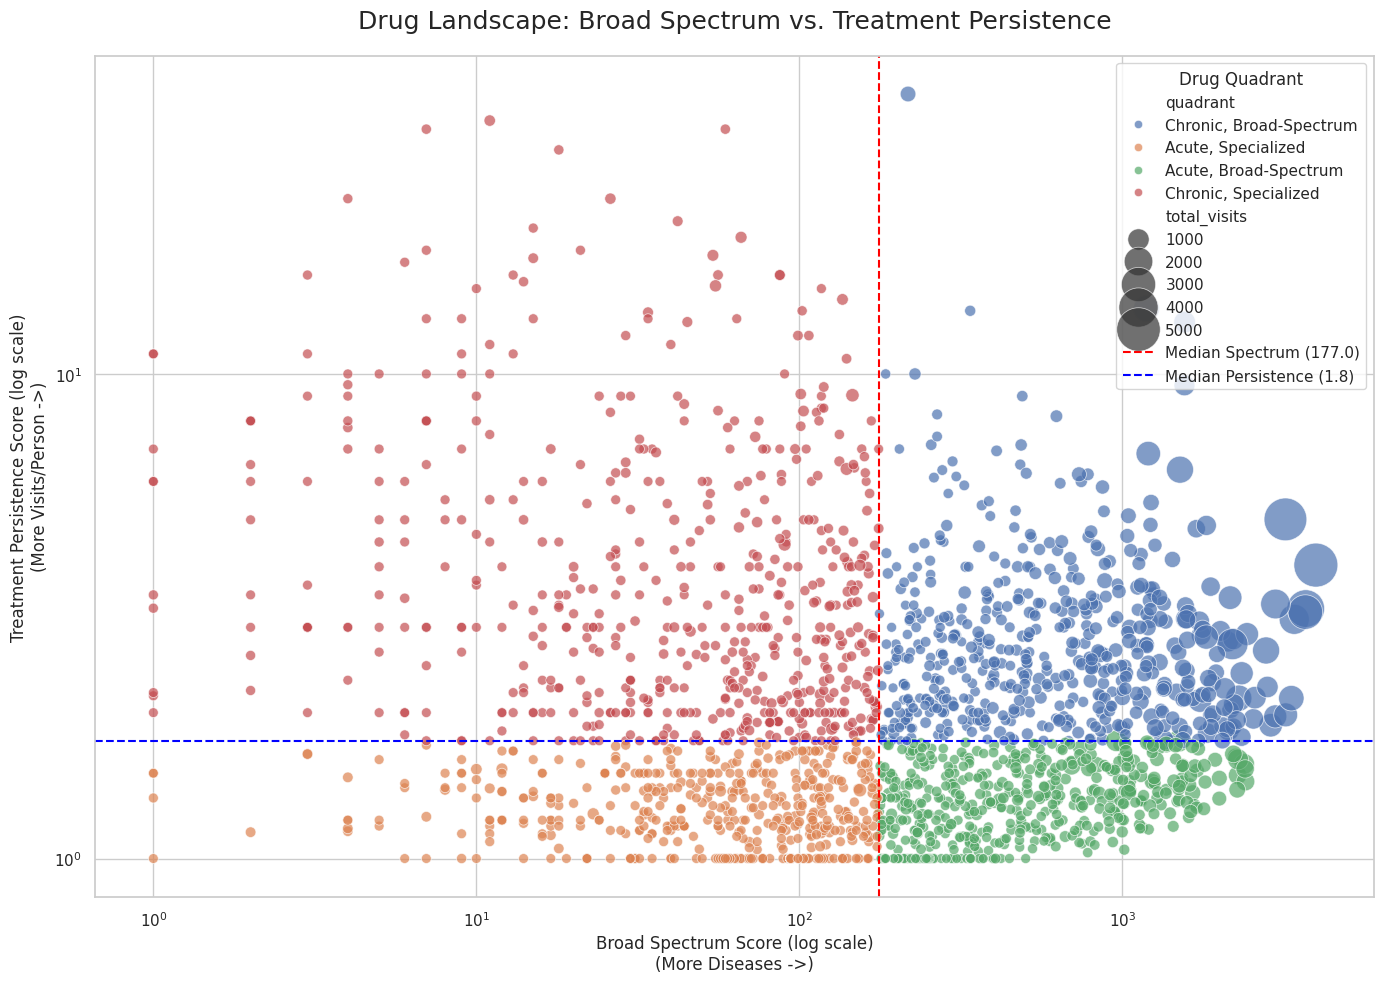

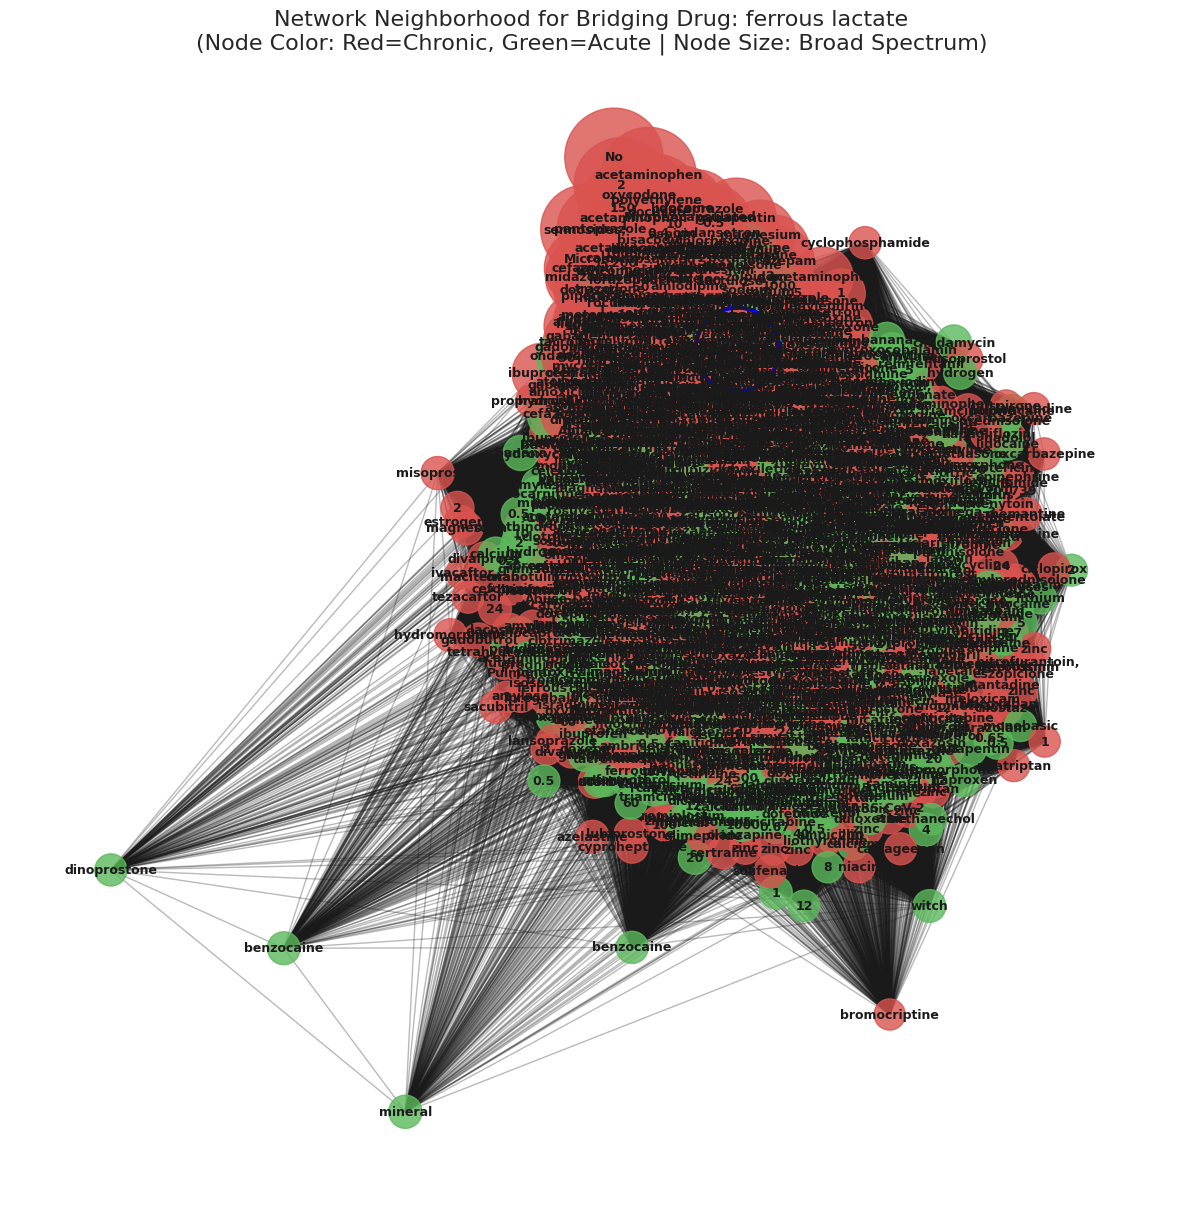

In [ ]:
# Source code
# https://github.com/VanDinhLe/GraphML/tree/main
import pandas as pd
import os
import torch
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # For better plotting
from sklearn.preprocessing import minmax_scale

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

print(f"PyG Version: {torch_geometric.__version__}")
print(f"NetworkX Version: {nx.__version__}")

# --- 1. Data Loading ---
def load_data_files(data_path):
    """
    Loads all necessary CSV files.
    """
    print("--- 1. Starting to load data files ---")
    
    files = {
        "concept": "concept.csv",
        "person": "sampled_person.csv",
        "condition": "sampled_condition_occurrence.csv",
        "drug": "sampled_drug_exposure.csv",
        "observation": "sampled_observation.csv"
    }
    
    data_dfs = {}
    
    for name, filename in files.items():
        path = os.path.join(data_path, filename)
        try:
            data_dfs[name] = pd.read_csv(path, low_memory=False)
            print(f"Successfully loaded: {filename} (Rows: {len(data_dfs[name])})")
        except FileNotFoundError:
            print(f"ERROR: File {filename} not found at {data_path}.")
            return None, None, None
            
    # Create concept_id -> name and domain dictionaries for mapping
    concept_df = data_dfs['concept']
    concept_map = concept_df.set_index('concept_id')['concept_name'].to_dict()
    domain_map = concept_df.set_index('concept_id')['domain_id'].to_dict()
    
    print("--- Data loading complete ---")
    return data_dfs, concept_map, domain_map

# --- 2. Graph Construction ---
def build_heterograph(data_dfs, concept_map, domain_map):
    """
    Constructs the HeteroData graph based on your 5 node types.
    This function is corrected to handle drug edges properly.
    """
    print("--- 2. Starting to build heterogeneous graph (HeteroData) ---")
    data = HeteroData()
    
    # --- 2.1 Define Nodes ---
    print("Processing nodes...")
    
    # Person nodes
    person_df = data_dfs['person'].drop_duplicates(subset=['person_id'])
    person_ids = person_df['person_id'].unique()
    person_map = {pid: i for i, pid in enumerate(person_ids)}
    data['person'].num_nodes = len(person_ids)
    data['person'].x = torch.tensor(person_df[['year_of_birth', 'gender_concept_id', 'race_concept_id']].fillna(0).values, dtype=torch.float)
    data['person'].person_id = torch.tensor(person_ids, dtype=torch.long)

    # Visit nodes (inferred from all event tables)
    condition_df = data_dfs['condition']
    drug_df = data_dfs['drug']
    observation_df = data_dfs['observation']
    
    visit_ids = set(condition_df['visit_occurrence_id'].dropna().unique())
    visit_ids.update(drug_df['visit_occurrence_id'].dropna().unique())
    visit_ids.update(observation_df['visit_occurrence_id'].dropna().unique())
    visit_ids = sorted(list(visit_ids))
    visit_map = {vid: i for i, vid in enumerate(visit_ids)}
    data['visit'].num_nodes = len(visit_ids)
    data['visit'].visit_id = torch.tensor(visit_ids, dtype=torch.long)

    # Disease nodes (from Condition Occurrence)
    disease_ids = condition_df['condition_concept_id'].dropna().unique()
    disease_map = {cid: i for i, cid in enumerate(disease_ids)}
    data['disease'].num_nodes = len(disease_ids)
    data['disease'].name = [concept_map.get(cid, 'Unknown Disease') for cid in disease_ids]
    data['disease'].concept_id = torch.tensor(disease_ids, dtype=torch.long)

    # Drug nodes (from Drug Exposure)
    drug_ids = drug_df['drug_concept_id'].dropna().unique()
    drug_map = {did: i for i, did in enumerate(drug_ids)}
    data['drug'].num_nodes = len(drug_ids)
    data['drug'].name = [concept_map.get(did, 'Unknown Drug') for did in drug_ids]
    data['drug'].concept_id = torch.tensor(drug_ids, dtype=torch.long)

    # Symptom nodes (from Observation)
    obs_ids = observation_df['observation_concept_id'].dropna().unique()
    symptom_ids = [oid for oid in obs_ids if domain_map.get(oid) == 'Observation']
    symptom_map = {sid: i for i, sid in enumerate(symptom_ids)}
    data['symptom'].num_nodes = len(symptom_ids)
    data['symptom'].name = [concept_map.get(sid, 'Unknown Symptom') for sid in symptom_ids]
    data['symptom'].concept_id = torch.tensor(symptom_ids, dtype=torch.long)

    # --- 2.2 Define Edges ---
    print("Processing edges...")
    
    # (Person) -> (Visit)
    pv_pairs = pd.concat([
        condition_df[['person_id', 'visit_occurrence_id']],
        drug_df[['person_id', 'visit_occurrence_id']],
        observation_df[['person_id', 'visit_occurrence_id']]
    ]).dropna().drop_duplicates()
    src = [person_map[p] for p in pv_pairs['person_id'] if p in person_map]
    dst = [visit_map[v] for v in pv_pairs['visit_occurrence_id'] if v in visit_map]
    data['person', 'had_visit', 'visit'].edge_index = torch.tensor([src, dst], dtype=torch.long)

    # (Visit) -> (Disease)
    vd_pairs = condition_df[['visit_occurrence_id', 'condition_concept_id']].dropna().drop_duplicates()
    src = [visit_map[v] for v in vd_pairs['visit_occurrence_id'] if v in visit_map]
    dst = [disease_map[d] for d in vd_pairs['condition_concept_id'] if d in disease_map]
    data['visit', 'had_condition', 'disease'].edge_index = torch.tensor([src, dst], dtype=torch.long)

    # (Visit) -> (Symptom)
    vs_pairs = observation_df[observation_df['observation_concept_id'].isin(symptom_map)]
    vs_pairs = vs_pairs[['visit_occurrence_id', 'observation_concept_id']].dropna().drop_duplicates()
    src = [visit_map[v] for v in vs_pairs['visit_occurrence_id'] if v in visit_map]
    dst = [symptom_map[s] for s in vs_pairs['observation_concept_id'] if s in symptom_map]
    data['visit', 'had_symptom', 'symptom'].edge_index = torch.tensor([src, dst], dtype=torch.long)

    # *** (Visit) -> (Drug) [CORRECTED LOGIC] ***
    print("Correctly building (visit, prescribed, drug) edges...")
    vdr_df = drug_df[['visit_occurrence_id', 'drug_concept_id', 'days_supply']].dropna(
        subset=['visit_occurrence_id', 'drug_concept_id']
    )
    vdr_df['days_supply'] = vdr_df['days_supply'].fillna(1.0) # Impute missing days_supply
    
    vdr_agg = vdr_df.groupby(['visit_occurrence_id', 'drug_concept_id']).agg(
        avg_days_supply=('days_supply', 'mean'),
        count=('visit_occurrence_id', 'size')
    ).reset_index()

    src, dst, edge_attrs_list = [], [], []
    for _, row in tqdm(vdr_agg.iterrows(), total=vdr_agg.shape[0], desc="Building drug edges"):
        if row['visit_occurrence_id'] in visit_map and row['drug_concept_id'] in drug_map:
            src.append(visit_map[row['visit_occurrence_id']])
            dst.append(drug_map[row['drug_concept_id']])
            edge_attrs_list.append([row['avg_days_supply'], row['count']])
            
    data['visit', 'prescribed', 'drug'].edge_index = torch.tensor([src, dst], dtype=torch.long)
    data['visit', 'prescribed', 'drug'].edge_attr = torch.tensor(edge_attrs_list, dtype=torch.float)

    # --- 2.3 Add reverse edges ---
    print("Adding reverse edges (ToUndirected)...")
    data = T.ToUndirected(merge=True)(data)

    print("--- Graph construction complete! ---")
    return data

# --- 3. Analysis Part 1: Drug Metrics (BS and TP) ---

def calculate_drug_metrics(data):
    """
    Calculates the 'Broad Spectrum' and 'Treatment Persistence' scores
    for every drug, based on your observations.
    """
    print("--- 3. Calculating custom drug metrics (BS & TP) ---")
    
    # Get the necessary edge indices for 2-hop lookups
    try:
        drug_to_visit_edges = data['drug', 'rev_prescribed', 'visit'].edge_index
        visit_to_disease_edges = data['visit', 'had_condition', 'disease'].edge_index
        visit_to_person_edges = data['visit', 'rev_had_visit', 'person'].edge_index
    except KeyError:
        print("ERROR: Cannot find required edges. Did graph construction fail?")
        return pd.DataFrame()

    drug_metrics = []
    
    for drug_idx in tqdm(range(data['drug'].num_nodes), desc="Analyzing all drugs"):
        drug_name = data['drug'].name[drug_idx]
        
        # Find all 'visit' nodes connected to this drug
        visit_indices = drug_to_visit_edges[1][drug_to_visit_edges[0] == drug_idx]
        num_visits = len(visit_indices)
        
        if num_visits == 0:
            drug_metrics.append({
                'drug_idx': drug_idx,
                'drug_name': drug_name,
                'spectrum_score': 0,
                'persistence_score': 0,
                'total_visits': 0,
                'total_persons': 0
            })
            continue

        # --- Metric 1: Broad Spectrum (Your Observation 4) ---
        # Find all unique 'disease' nodes 2-hops away
        visit_mask_d = torch.isin(visit_to_disease_edges[0], visit_indices)
        disease_indices = visit_to_disease_edges[1][visit_mask_d]
        spectrum_score = len(torch.unique(disease_indices))
        
        # --- Metric 2: Treatment Persistence (Your Observations 2 & 3) ---
        # Find all unique 'person' nodes 2-hops away
        visit_mask_p = torch.isin(visit_to_person_edges[0], visit_indices)
        person_indices = visit_to_person_edges[1][visit_mask_p]
        num_unique_persons = len(torch.unique(person_indices))
        
        if num_unique_persons == 0:
            persistence_score = float('inf') 
        else:
            persistence_score = num_visits / num_unique_persons
            
        drug_metrics.append({
            'drug_idx': drug_idx,
            'drug_name': drug_name,
            'spectrum_score': spectrum_score,
            'persistence_score': persistence_score,
            'total_visits': num_visits,
            'total_persons': num_unique_persons
        })
        
    print("--- Metric calculation complete ---")
    return pd.DataFrame(drug_metrics)

# --- 4. Analysis Part 2: Quadrant Analysis (Visualization) ---

def visualize_quadrant_analysis(metrics_df):
    """
    Creates a 2x2 scatter plot to visualize the drug landscape.
    """
    print("--- 4. Generating Quadrant Analysis Plot ---")
    
    # We focus on drugs with at least some activity
    df = metrics_df[(metrics_df['total_visits'] > 5) & (metrics_df['total_persons'] > 0)].copy()
    
    if df.empty:
        print("No drugs with sufficient data to plot.")
        return

    # Use median to define the quadrants
    median_spectrum = df['spectrum_score'].median()
    median_persistence = df['persistence_score'].median()
    
    # Create the quadrant labels
    def assign_quadrant(row):
        if row['spectrum_score'] >= median_spectrum and row['persistence_score'] >= median_persistence:
            return "Chronic, Broad-Spectrum"
        elif row['spectrum_score'] < median_spectrum and row['persistence_score'] >= median_persistence:
            return "Chronic, Specialized"
        elif row['spectrum_score'] >= median_spectrum and row['persistence_score'] < median_persistence:
            return "Acute, Broad-Spectrum"
        else:
            return "Acute, Specialized"
            
    df['quadrant'] = df.apply(assign_quadrant, axis=1)
    
    # --- Plotting ---
    plt.figure(figsize=(14, 10))
    sns.set_theme(style="whitegrid")
    
    plot = sns.scatterplot(
        data=df,
        x='spectrum_score',
        y='persistence_score',
        hue='quadrant',
        palette="deep",
        size='total_visits',
        sizes=(50, 1000),
        alpha=0.7
    )
    
    # Add median lines
    plt.axvline(median_spectrum, color='red', linestyle='--', label=f'Median Spectrum ({median_spectrum:.1f})')
    plt.axhline(median_persistence, color='blue', linestyle='--', label=f'Median Persistence ({median_persistence:.1f})')
    
    # Log scale for better visualization, as these metrics can have long tails
    plt.xscale('log')
    plt.yscale('log')
    
    plt.title('Drug Landscape: Broad Spectrum vs. Treatment Persistence', fontsize=18, pad=20)
    plt.xlabel('Broad Spectrum Score (log scale)\n(More Diseases ->)', fontsize=12)
    plt.ylabel('Treatment Persistence Score (log scale)\n(More Visits/Person ->)', fontsize=12)
    plt.legend(title='Drug Quadrant', loc='best')
    plt.tight_layout()
    
    print("Displaying Quadrant Analysis Plot...")
    #     plt.show()
    
    # --- Print examples from each quadrant ---
    print("\n--- Quadrant Analysis Insights ---")
    print("\n**Quadrant 1: Chronic, Broad-Spectrum (Top Right)**")
    print("Drugs for common, chronic conditions. (e.g., Metformin, Lisinopril)")
    print(df[df['quadrant'] == 'Chronic, Broad-Spectrum'].sort_values('total_visits', ascending=False).head(3)['drug_name'].to_string(index=False))

    print("\n**Quadrant 2: Chronic, Specialized (Top Left)**")
    print("Drugs for rare or specialized chronic conditions. (e.g., Chemotherapy, specific biologics)")
    print(df[df['quadrant'] == 'Chronic, Specialized'].sort_values('total_visits', ascending=False).head(3)['drug_name'].to_string(index=False))

    print("\n**Quadrant 3: Acute, Broad-Spectrum (Bottom Right)**")
    print("Common 'one-time' treatments. (e.g., Ibuprofen, common antibiotics)")
    print(df[df['quadrant'] == 'Acute, Broad-Spectrum'].sort_values('total_visits', ascending=False).head(3)['drug_name'].to_string(index=False))

    print("\n**Quadrant 4: Acute, Specialized (Bottom Left)**")
    print("Specialized, 'one-time' treatments. (e.g., Anesthetics for surgery, specific antidotes)")
    print(df[df['quadrant'] == 'Acute, Specialized'].sort_values('total_visits', ascending=False).head(3)['drug_name'].to_string(index=False))


# --- 5. Analysis Part 3: Bridging Centrality (Advanced SNA) ---

def build_drug_co_treatment_graph(data):
    """
    Builds a homogeneous Drug-Drug graph.
    Edge(A, B) weight = Jaccard similarity of diseases they BOTH treat.
    This is a "co-occurrence network"[cite: 68].
    """
    print("--- 5. Building Drug-Drug Co-treatment Graph ---")
    
    # 1. Find all (drug_idx, disease_idx) pairs via 'visit' nodes
    dv_edges = data['drug', 'rev_prescribed', 'visit'].edge_index.t()
    df_dv = pd.DataFrame(dv_edges.numpy(), columns=['drug_idx', 'visit_idx'])
    
    vd_edges = data['visit', 'had_condition', 'disease'].edge_index.t()
    df_vd = pd.DataFrame(vd_edges.numpy(), columns=['visit_idx', 'disease_idx'])
    
    print("Merging Drug-Visit and Visit-Disease links...")
    df_drug_disease = pd.merge(df_dv, df_vd, on='visit_idx').drop_duplicates(subset=['drug_idx', 'disease_idx'])
    
    # 2. Create a dictionary: drug_idx -> set(disease_idx)
    drug_to_disease_set = df_drug_disease.groupby('drug_idx')['disease_idx'].apply(set)
    
    # 3. Build NetworkX graph and calculate Jaccard similarity
    G_drug = nx.Graph()
    drug_indices = list(drug_to_disease_set.index)
    
    for i in tqdm(range(len(drug_indices)), desc="Building Drug-Drug graph (Jaccard)"):
        for j in range(i + 1, len(drug_indices)):
            idx_a = drug_indices[i]
            idx_b = drug_indices[j]
            
            set_a = drug_to_disease_set.get(idx_a, set())
            set_b = drug_to_disease_set.get(idx_b, set())
            
            intersection = len(set_a.intersection(set_b))
            if intersection > 0:
                union = len(set_a.union(set_b))
                jaccard_sim = intersection / union
                if jaccard_sim > 0.05: # Threshold to keep graph manageable
                    G_drug.add_edge(idx_a, idx_b, weight=jaccard_sim)
                    
    print(f"Drug-Drug graph built: {G_drug.number_of_nodes()} nodes, {G_drug.number_of_edges()} edges.")
    return G_drug

def analyze_bridging_drugs(G_drug, metrics_df):
    """
    Applies Betweenness Centrality  to find 'bridging' drugs.
    """
    if G_drug.number_of_edges() == 0:
        print("Drug-Drug graph is empty, skipping centrality analysis.")
        return metrics_df

    print("--- 6. Calculating Betweenness Centrality ---")
    
    # Calculate centrality. This is computationally expensive.
    # We use 'weight' (Jaccard similarity) - paths with HIHGER similarity are 'shorter'.
    # We must invert the weights for shortest_path calculation.
    for u, v, d in G_drug.edges(data=True):
        d['inverted_weight'] = 1.0 - d['weight']
        
    centrality = nx.betweenness_centrality(
        G_drug, 
        weight='inverted_weight', 
        normalized=True,
        k=int(G_drug.number_of_nodes() * 0.1) # Sample k nodes for performance
    )
    
    # Add centrality to our metrics dataframe
    metrics_df['betweenness_centrality'] = metrics_df['drug_idx'].map(centrality).fillna(0)
    
    print("\n--- Bridging Drug Analysis (Top 10) ---")
    top_bridges = metrics_df.sort_values('betweenness_centrality', ascending=False).head(10)
    print(top_bridges[['drug_name', 'betweenness_centrality', 'spectrum_score', 'persistence_score']].to_markdown(index=False, floatfmt=".4f"))
    
    print("\n--- Interpretation of Bridging Drugs ---")
    print("RQ: Which diagnoses act as bridges between otherwise separate clusters? ")
    print("Interpretation: The drugs with the highest 'betweenness_centrality' are 'bridging' drugs. This means they connect clusters of drugs that are otherwise unrelated.")
    print("Medical Insight: These are often 'comorbidity' drugs. For example, a drug that treats both 'Diabetes' and 'Kidney Disease' (a common complication) would bridge the 'Diabetes drug' community and the 'Kidney drug' community.")
    print("The top drugs listed above are candidates for this 'bridging' role.")
    
    return metrics_df, G_drug

def visualize_bridging_subgraph(G_drug, metrics_df, top_bridge_name):
    """
    Visualizes a high-centrality drug and its immediate community.
    """
    print(f"--- 7. Visualizing Subgraph for Bridging Drug: {top_bridge_name} ---")
    
    try:
        # Find the index of the top bridge
        top_bridge_idx = metrics_df[metrics_df['drug_name'] == top_bridge_name]['drug_idx'].iloc[0]
        
        if top_bridge_idx not in G_drug:
            print(f"Drug '{top_bridge_name}' is not in the co-treatment graph (it may be isolated).")
            return

        # Get the 1-hop neighbors of this drug
        neighbors = list(G_drug.neighbors(top_bridge_idx))
        if not neighbors:
            print(f"Drug '{top_bridge_name}' has no neighbors in the graph.")
            return
            
        nodes_to_draw = [top_bridge_idx] + neighbors
        
        # Create the subgraph
        G_sub = G_drug.subgraph(nodes_to_draw)
        
        # --- Visualization ---
        plt.figure(figsize=(15, 15))
        pos = nx.spring_layout(G_sub, k=0.8)
        
        # Node colors based on 'Persistence' (Chronic vs Acute)
        node_colors = []
        persistence_map = metrics_df.set_index('drug_idx')['persistence_score']
        median_persistence = persistence_map.median()
        
        for node in G_sub.nodes():
            score = persistence_map.get(node, median_persistence)
            if score >= median_persistence:
                node_colors.append('#d9534f') # Red (Chronic)
            else:
                node_colors.append('#5cb85c') # Green (Acute)
        
        # Node sizes based on 'Spectrum' (Broad vs Specialized)
        node_sizes = [metrics_df.set_index('drug_idx')['spectrum_score'].get(n, 10) for n in G_sub.nodes()]
        node_sizes = minmax_scale(node_sizes, feature_range=(500, 5000))
        
        # Draw the graph
        nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
        
        # Draw edges
        nx.draw_networkx_edges(G_sub, pos, alpha=0.3)
        
        # Draw labels
        labels = {n: metrics_df.set_index('drug_idx')['drug_name'].get(n, 'Unknown').split(' ')[0] for n in G_sub.nodes()}
        nx.draw_networkx_labels(G_sub, pos, labels=labels, font_size=9, font_weight='bold')
        
        # Highlight the central node
        nx.draw_networkx_nodes(G_sub, pos, nodelist=[top_bridge_idx], node_size=node_sizes[0], 
                               edgecolors='blue', node_color=node_colors[0], linewidths=3)
        
        plt.title(f"Network Neighborhood for Bridging Drug: {top_bridge_name}\n(Node Color: Red=Chronic, Green=Acute | Node Size: Broad Spectrum)", fontsize=16)
        plt.axis('off')
        
        print("Displaying Bridging Subgraph Visualization...")
        #         plt.show()

    except Exception as e:
        print(f"Error during visualization: {e}")


# --- Main Execution ---
if __name__ == "__main__":
    
    # !! PLEASE UPDATE THIS PATH !!
    DATA_PATH = "/home/henry/Desktop/LLM/GraphML/data/"
    
    # 1. Load Data
    all_dfs, concept_map, domain_map = load_data_files(DATA_PATH)
    
    if all_dfs:
        # 2. Build Graph
        graph_data = build_heterograph(all_dfs, concept_map, domain_map)
        print("\n--- Final Graph Summary ---")
        print(graph_data)
        
        # Check if drug edges were successfully created
        if graph_data['visit', 'prescribed', 'drug'].num_edges == 0:
            print("\nCRITICAL ERROR: No (visit, drug) edges were created.")
            print("Please check 'sampled_drug_exposure.csv' for valid data.")
        else:
            print(f"\nSuccessfully built {graph_data['visit', 'prescribed', 'drug'].num_edges} (visit, drug) edges.")
            
            # 3. Calculate Metrics (BS & TP)
            drug_metrics_df = calculate_drug_metrics(graph_data)
            
            # 4. Quadrant Analysis
            visualize_quadrant_analysis(drug_metrics_df)
            
            # 5. Bridging Drug Analysis (Centrality)
            # Build the D-D graph
            G_drug_drug = build_drug_co_treatment_graph(graph_data)
            
            # Run centrality analysis
            drug_metrics_df, G_drug_drug = analyze_bridging_drugs(G_drug_drug, drug_metrics_df)
            
            # 6. Visualize Top Bridge
            if not drug_metrics_df.empty and 'betweenness_centrality' in drug_metrics_df.columns:
                top_drug_name = drug_metrics_df.sort_values('betweenness_centrality', ascending=False).iloc[0]['drug_name']
                visualize_bridging_subgraph(G_drug_drug, drug_metrics_df, top_drug_name)
            
            print("\n--- Project Analysis Complete ---")

PyG Version: 2.7.0
NetworkX Version: 3.5


--- 1. Starting to load data files ---
--- Data loading complete ---
--- 2. Starting to build heterogeneous graph (HeteroData) ---
--- Graph construction complete! ---
--- 3. Calculating custom drug metrics (BS & TP) ---


Analyzing all drugs:   0%|          | 0/4110 [00:00<?, ?it/s]

--- Metric calculation complete ---
--- 5. Building Drug-Drug Co-treatment Graph ---
Merging Drug-Visit and Visit-Disease links...


Building Drug-Drug graph (Jaccard):   0%|          | 0/3938 [00:00<?, ?it/s]

Drug-Drug graph built: 3916 nodes, 1997275 edges.
--- 6. Calculating Betweenness Centrality ---

--- Bridging Drug Analysis (Top 10) ---
| drug_name             |   betweenness_centrality |   spectrum_score |   persistence_score |
|:----------------------|-------------------------:|-----------------:|--------------------:|
| ferrous lactate       |              145982.0681 |             1058 |              1.3813 |
| calcium pyrophosphate |              140488.0033 |               94 |              1.0000 |
| ferrous carbonate     |               72991.0338 |             1058 |              1.3813 |
| calcium malate        |               70244.0013 |               94 |              1.0000 |
| iron,peptonized       |               36495.5167 |             1058 |              1.3813 |
| calcium               |               35122.0003 |               94 |              1.0000 |
| ferrous chloride      |               18247.7581 |             1058 |              1.3813 |
| calcium carbona

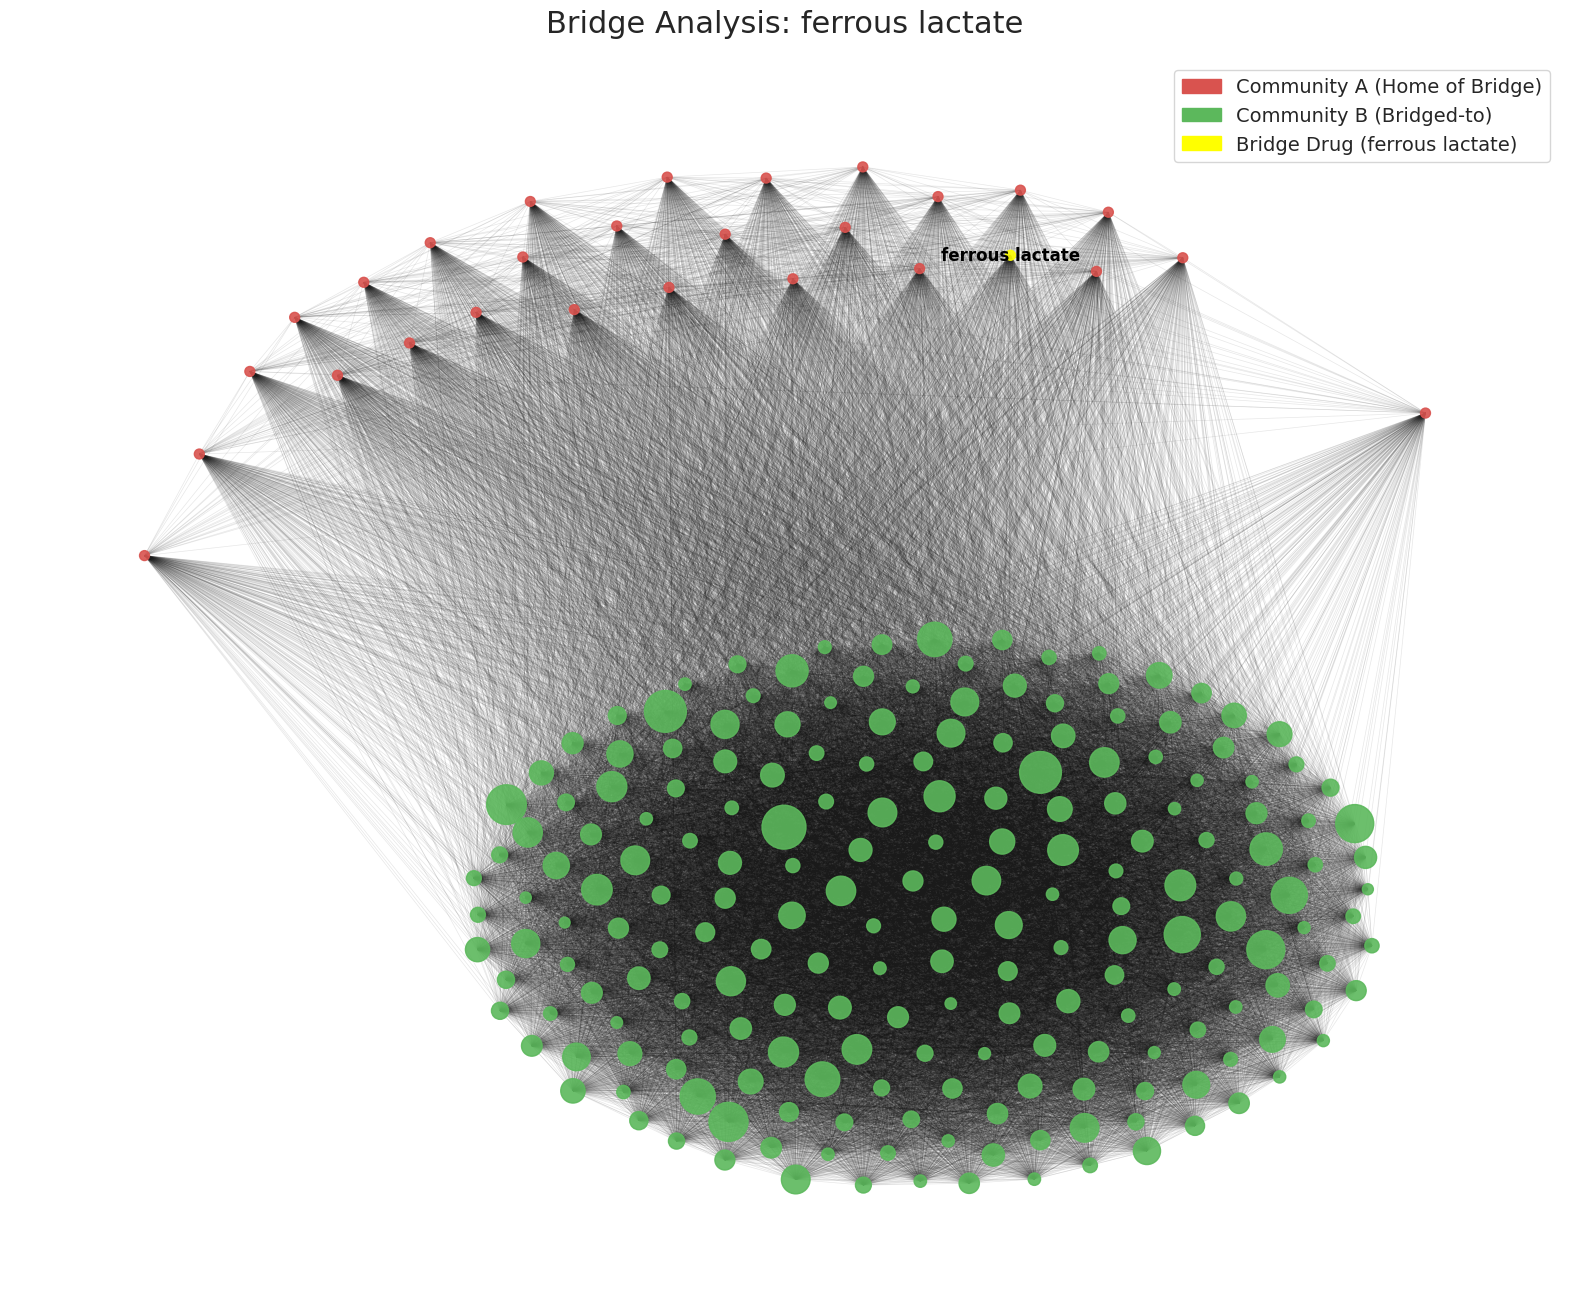


--- Project Analysis Complete ---


In [15]:
import pandas as pd
import os
import torch
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import minmax_scale
import matplotlib.patches as mpatches # For custom legends

# Import Louvain community detection
from networkx.algorithms.community import louvain_communities


def visualize_community_bridge_graph(G_drug_drug, metrics_df, top_bridge_name):
    """
    Generates a clear visualization of a bridging drug by:
    1. Finding its main community (A).
    2. Finding the community it most connects to (B).
    3. Drawing ONLY these two communities, using a layout
       that pulls them apart to show the bridging links.
    """
    print(f"--- 8. Generating Advanced Bridge Visualization for: {top_bridge_name} ---")

    # 1. --- Run Community Detection ---
    print("Running Louvain community detection on Drug-Drug graph...")
    # We need a graph with only positive weights for Louvain
    G_community = G_drug_drug.copy()
    # Remove edges with 0 or negative Jaccard similarity (if any)
    edges_to_remove = [(u, v) for u, v, w in G_community.edges(data='weight') if w <= 0]
    G_community.remove_edges_from(edges_to_remove)
    
    # Higher resolution finds smaller, more distinct communities
    communities = louvain_communities(G_community, weight='weight', resolution=2.0, seed=42)
    
    # Create a node -> community_id map
    node_community_map = {}
    for i, comm in enumerate(communities):
        for node_idx in comm:
            node_community_map[node_idx] = i
    
    print(f"Found {len(communities)} drug communities.")

    # 2. --- Identify Communities A and B ---
    metrics_indexed = metrics_df.set_index('drug_idx')
    try:
        top_bridge_idx = metrics_indexed[metrics_indexed['drug_name'] == top_bridge_name].index[0]
        if top_bridge_idx not in node_community_map:
            print(f"Error: Bridging drug '{top_bridge_name}' was not found in a community (it may be an isolate).")
            return
    except IndexError:
        print(f"Error: Could not find drug '{top_bridge_name}' in metrics.")
        return

    community_A_id = node_community_map[top_bridge_idx]

    # Find which *other* community its neighbors most belong to
    neighbor_communities = []
    for neighbor in G_drug_drug.neighbors(top_bridge_idx):
        if neighbor in node_community_map:
            comm_id = node_community_map[neighbor]
            if comm_id != community_A_id:
                neighbor_communities.append(comm_id)
    
    if not neighbor_communities:
        print(f"Warning: Bridging drug '{top_bridge_name}' only connects within its own community. Visualizing its home community.")
        community_B_id = community_A_id
    else:
        # Find the most common neighbor community (Community B)
        community_B_id = max(set(neighbor_communities), key=neighbor_communities.count)

    print(f"Bridging drug is in community: {community_A_id}")
    print(f"It most actively bridges to community: {community_B_id}")

    # 3. --- Create Subgraph with only nodes from Comms A & B ---
    nodes_A = [n for n, comm_id in node_community_map.items() if comm_id == community_A_id]
    nodes_B = [n for n, comm_id in node_community_map.items() if comm_id == community_B_id]
    
    nodes_to_draw = set(nodes_A + nodes_B)
    G_sub = G_drug_drug.subgraph(nodes_to_draw)

    # 4. --- Edge Pruning: Remove weak edges for visual clarity ---
    # Only keep edges with Jaccard similarity > 0.1 (tweak this threshold)
    G_pruned = G_sub.copy()
    jaccard_threshold = 0.1
    edges_to_remove = [(u, v) for u, v, w in G_pruned.edges(data='weight') if w < jaccard_threshold]
    G_pruned.remove_edges_from(edges_to_remove)
    # Also remove isolated nodes
    G_pruned.remove_nodes_from(list(nx.isolates(G_pruned)))
    
    print(f"Visualizing subgraph: {G_pruned.number_of_nodes()} nodes, {G_pruned.number_of_edges()} edges (after pruning).")

    if G_pruned.number_of_nodes() == 0:
        print("Subgraph is empty after pruning. Cannot visualize.")
        return
        
    # 5. --- Create Layout Graph ---
    # We create a "layout" graph where intra-community edges are
    # much stronger than inter-community edges.
    G_layout = nx.Graph()
    G_layout.add_nodes_from(G_pruned.nodes())
    
    for u, v in G_pruned.edges():
        layout_weight = 1.0 # Strong pull
        if node_community_map.get(u) != node_community_map.get(v):
            layout_weight = 0.1 # Weak pull (the bridge)
        G_layout.add_edge(u, v, weight=layout_weight)

    # 6. --- Calculate Layout and Colors ---
    print("Calculating smart layout...")
    pos = nx.spring_layout(G_layout, weight='weight', k=0.8, iterations=70, seed=42)
    
    # Assign colors
    colors = []
    for node in G_pruned.nodes():
        if node == top_bridge_idx:
            colors.append('#FFFF00') # Yellow (The Bridge)
        elif node_community_map.get(node) == community_A_id:
            colors.append('#d9534f') # Red (Community A)
        else:
            colors.append('#5cb85c') # Green (Community B)

    # Node sizes based on 'Spectrum' (Broad vs Specialized)
    node_sizes = [metrics_indexed.loc[n]['spectrum_score'] for n in G_pruned.nodes()]
    node_sizes = minmax_scale(node_sizes, feature_range=(50, 1000))

    # 7. --- Draw the Graph ---
    print("Drawing final graph...")
    plt.figure(figsize=(20, 16))
    
    # Draw edges
    nx.draw_networkx_edges(
        G_pruned, 
        pos, 
        alpha=0.1,
        width=0.5
    )
    
    # Draw nodes
    nx.draw_networkx_nodes(
        G_pruned, 
        pos, 
        node_color=colors, 
        node_size=node_sizes, 
        alpha=0.9
    )
    
    # Draw a label ONLY for the bridging drug
    nx.draw_networkx_labels(
        G_pruned, 
        pos, 
        labels={top_bridge_idx: top_bridge_name},
        font_size=12,
        font_weight='bold',
        font_color='black'
    )
    
    plt.title(f"Bridge Analysis: {top_bridge_name}", fontsize=22, pad=20)
    plt.axis('off')

    # Create custom legend
    comm_A_patch = mpatches.Patch(color='#d9534f', label=f'Community A (Home of Bridge)')
    comm_B_patch = mpatches.Patch(color='#5cb85c', label=f'Community B (Bridged-to)')
    bridge_patch = mpatches.Patch(color='#FFFF00', label=f'Bridge Drug ({top_bridge_name})')
    
    plt.legend(handles=[comm_A_patch, comm_B_patch, bridge_patch], 
               loc='upper right', 
               bbox_to_anchor=(1, 1), 
               fontsize=14)
    
    # 
    plt.show()


if __name__ == "__main__":
    DATA_PATH = "/home/henry/Desktop/LLM/GraphML/data/"
    all_dfs, concept_map, domain_map = load_data_files(DATA_PATH)
    
    if all_dfs:
        graph_data = build_heterograph(all_dfs, concept_map, domain_map)
        
        if graph_data['visit', 'prescribed', 'drug'].num_edges > 0:
            
            drug_metrics_df = calculate_drug_metrics(graph_data)
            
            G_drug_drug = build_drug_co_treatment_graph(graph_data)
            
            drug_metrics_df, G_drug_drug = analyze_bridging_drugs(G_drug_drug, drug_metrics_df)
            
            if not drug_metrics_df.empty and 'betweenness_centrality' in drug_metrics_df.columns:
                top_drug_name = drug_metrics_df.sort_values('betweenness_centrality', ascending=False).iloc[0]['drug_name']
                visualize_community_bridge_graph(G_drug_drug, drug_metrics_df, top_drug_name)
            
            print("\n--- Project Analysis Complete ---")
        else:
            print("\nCRITICAL ERROR: No (visit, drug) edges were created.")